<a href="https://colab.research.google.com/github/yuseifer/TFM_2024/blob/main/Entrenador_sac_HER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym==0.17.3
!pip install pybullet==3.2.6
!pip install stable_baselines3[extra]
!pip install shimmy==1.2.1
!pip install gymnasium==0.28.1
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.1 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654616 sha256=d1ddb275d91b29bdbe0a66dfd06b01387e21d4cda0d2d7161e1d97530a04f937
  Stored in directory: /root/.cache/pip/wheels/af/4b/74/fcfc8238472c34d7f96508a63c962ff3ac9485a9a4137afd4e
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 3.1.0
    Uninstalling cloudpickle-3.1.0:
      Successfully uninstalled cloudpickle-3.1.0
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.25.0 requires cloudpickl

In [ ]:
!unzip ant_custom.zip

Archive:  ant_custom.zip
   creating: ant_custom/
   creating: ant_custom/CustomAnt_Env/
   creating: ant_custom/CustomAnt_Env/envs/
  inflating: ant_custom/CustomAnt_Env/envs/AntCustomEnvEmpty.py  
  inflating: ant_custom/CustomAnt_Env/envs/__init__.py  
   creating: ant_custom/CustomAnt_Env/resources/
  inflating: ant_custom/CustomAnt_Env/resources/antcustom.py  
  inflating: ant_custom/CustomAnt_Env/resources/Cil_obs.py  
  inflating: ant_custom/CustomAnt_Env/resources/goal.py  
  inflating: ant_custom/CustomAnt_Env/resources/plane.py  
  inflating: ant_custom/CustomAnt_Env/resources/simplegoal.urdf  
  inflating: ant_custom/CustomAnt_Env/resources/simpleobstacle.urdf  
  inflating: ant_custom/CustomAnt_Env/resources/simpleplane.urdf  
  inflating: ant_custom/CustomAnt_Env/__init__.py  
  inflating: ant_custom/setup.py     


In [ ]:
import gym
import pybullet, pybullet_envs
import torch as th

from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
#Importamos librerías para realizar el multiprocesos y normalización del entorno
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.env_util import make_vec_env

import gym
import sys
from tensorboardX import SummaryWriter

sys.path.append('/content/ant_custom')
import CustomAnt_Env

In [ ]:
import torch
#We begin with training but first we set some hyperparameters
SEED                = 42
NUM_ENVS            = 8
ENV_ID              = 'AntCustomEnv-v0'
HIDDEN_SIZE         = 256
LEARNING_RATE       = 1e-4
GAMMA               = 0.99
GAE_LAMBDA          = 0.95
PPO_EPSILON         = 0.2
CRITIC_DISCOUNT     = 0.5
ENTROPY_BETA        = 0.001
PPO_STEPS           = 256
MINI_BATCH_SIZE     = 64
PPO_EPOCHS          = 10
TEST_EPOCHS         = 10
NUM_TESTS           = 10
TARGET_REWARD       = 50
MAX_STEPS           = 10000
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create the env
env = gym.make(ENV_ID)

# Get the state space and action space
s_size = env.observation_space.shape

a_size = env.action_space

In [ ]:
MAX_AVERAGE_SCORE = 50e6
#Definimos la arquitectura de la red
policy_kwargs = dict(activation_fn=th.nn.LeakyReLU, net_arch=[512, 512])
#policy_kwargs = dict(activation_fn=th.nn.Tanh, net_arch=[512, 512, 264])

In [ ]:
import numpy as np

def evaluar_modelo(model, num_tests, env):
    rewards = []
    for i in range(num_tests):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    return mean_reward, std_reward

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback

# Crear el callback de evaluación, evaluando cada 10,000 steps y guardando el mejor modelo
eval_callback = EvalCallback(env, best_model_save_path='./logs/best_model/',
                             log_path='./logs/eval/', eval_freq=10000,
                             deterministic=True, render=False)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
import os
import pandas as pd
from stable_baselines3 import PPO



path_save = "/content/"
model = PPO('MultiInputPolicy', env,learning_rate=3e-4,policy_kwargs=policy_kwargs, verbose=1, batch_size=64)
print("Model created")
iteraciones = []
recompensa_promedio=[]

os.makedirs(path_save, exist_ok=True)





mean_rewards = []
for i in range(10):
  print("Training itteration ",i)
  model.learn(total_timesteps=100000,log_interval = 10,callback=eval_callback)
  # Save the agent

  model.save(path_save+"PPO_Ant")
  mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=5)
  mean_rewards.append(mean_reward)
  print(f'mean reward: {mean_reward}, std reward: +/-{std_reward}')




del model

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model created
Training itteration  0


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Eval num_timesteps=7600, episode_reward=-859.51 +/- 1996.22
Episode length: 10001.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 1e+04       |
|    mean_reward          | -860        |
| time/                   |             |
|    total_timesteps      | 7600        |
| train/                  |             |
|    approx_kl            | 0.012838498 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.2       |
|    explained_variance   | 0.35        |
|    learning_rate        | 0.0003      |
|    loss                 | 4.28        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0177     |
|    std                  | 0.98        |
|    value_loss           | 12.4        |
-----------------------------------------
Eval num_timesteps=17600, episode_reward=27.12 +/- 2093.75
Episode length: 10001.00 +/- 0.00
---------------

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
import os
import pandas as pd
from stable_baselines3 import HerReplayBuffer, SAC
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy


path_save = "/content/drive/MyDrive/Ant_custom/"

iteraciones = []
recompensa_promedio=[]

os.makedirs(path_save, exist_ok=True)


if os.path.exists("/content/drive/MyDrive/Ant_custom/SAC_Ant.zip"):
    model = SAC.load("/content/drive/MyDrive/Ant_custom/SAC_Ant.zip", env = env)
    print("Model loaded")
else:
    model = SAC('MlpPolicy', env,learning_rate=3e-4,policy_kwargs=policy_kwargs, verbose=1, batch_size=64)
    print("Model created")


mean_rewards = []
for i in range(10):
  print("Training itteration ",i)
  model.learn(total_timesteps=10000,log_interval = 10,callback=eval_callback)
  # Save the agent

  model.save(path_save+"SAC_Ant_ayudame_dios")
  mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=5)
  mean_rewards.append(mean_reward)
  print(f'mean reward: {mean_reward}, std reward: +/-{std_reward}')




del model


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


ValueError: Observation spaces do not match: Box([-10.        -10.        -10.         -3.1415927  -3.1415927  -3.1415927
 -10.        -10.        -20.        -20.        -20.        -20.
 -20.        -20.       ], [10.        10.        10.         3.1415927  3.1415927  3.1415927
 10.        10.        20.        20.        20.        20.
 20.        20.       ], (14,), float32) != Dict('desired_goal': Box(-inf, inf, (2,), float32), 'observation': Box(-inf, inf, (20,), float32))

In [ ]:
env.close()

In [ ]:
import gym
import pybullet, pybullet_envs
import torch as th

from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
#Importamos librerías para realizar el multiprocesos y normalización del entorno
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.env_util import make_vec_env

import gym
import sys
from tensorboardX import SummaryWriter

sys.path.append('/content/ant_custom')
import CustomAnt_Env

In [ ]:
import torch
#We begin with training but first we set some hyperparameters
SEED                = 42
NUM_ENVS            = 8
ENV_ID              = 'AntCustomEnv-v0'
HIDDEN_SIZE         = 256
LEARNING_RATE       = 1e-4
GAMMA               = 0.99
GAE_LAMBDA          = 0.95
PPO_EPSILON         = 0.2
CRITIC_DISCOUNT     = 0.5
ENTROPY_BETA        = 0.001
PPO_STEPS           = 256
MINI_BATCH_SIZE     = 64
PPO_EPOCHS          = 10
TEST_EPOCHS         = 10
NUM_TESTS           = 10
TARGET_REWARD       = 50
MAX_STEPS           = 10000
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
import os
import pandas as pd
from stable_baselines3 import HerReplayBuffer, SAC
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy

env = gym.make(ENV_ID)
n_sampled_goal = 4

model = SAC(
    "MultiInputPolicy",
    env,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=dict(
      n_sampled_goal=n_sampled_goal,
      goal_selection_strategy="final",
    ),
    verbose=1,
    buffer_size=int(1e6),
    learning_rate=1e-3,
    gamma=0.95,
    batch_size=256,
    policy_kwargs=dict(net_arch=[256, 256, 256]),learning_starts=11000
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
import os
iteraciones = []
recompensa_promedio=[]
mean_rewards = []
path_save = "/content/drive/MyDrive/Ant_custom/"

for i in range(10):
  print("Training itteration ",i)
  model.learn(total_timesteps=100000)
  # Save the agent
  model.save(path_save+"SAC_HER")
  mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=5)
  mean_rewards.append(mean_reward)
  print(f'mean reward: {mean_reward}, std reward: +/-{std_reward}')
del model

Training itteration  0
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 4.64e+03  |
|    ep_rew_mean     | 2.01e+03  |
| time/              |           |
|    episodes        | 4         |
|    fps             | 115       |
|    time_elapsed    | 160       |
|    total_timesteps | 18571     |
| train/             |           |
|    actor_loss      | -8.58e+04 |
|    critic_loss     | 3.12e+06  |
|    ent_coef        | 64.3      |
|    ent_coef_loss   | -3.89     |
|    learning_rate   | 0.001     |
|    n_updates       | 7570      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 4.01e+03  |
|    ep_rew_mean     | 914       |
| time/              |           |
|    episodes        | 8         |
|    fps             | 74        |
|    time_elapsed    | 431       |
|    total_timesteps | 32074     |
| train/             |           |
|    actor_loss      | -8.67e+04

In [ ]:
model.learn(int(10e5))
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
model.save("her_sac_highway")

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 3.02e+03  |
|    ep_rew_mean     | -255      |
| time/              |           |
|    episodes        | 4         |
|    fps             | 364       |
|    time_elapsed    | 33        |
|    total_timesteps | 12096     |
| train/             |           |
|    actor_loss      | -1.63e+04 |
|    critic_loss     | 3.58e+05  |
|    ent_coef        | 2.02      |
|    ent_coef_loss   | -5.29     |
|    learning_rate   | 0.001     |
|    n_updates       | 1095      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2.84e+03  |
|    ep_rew_mean     | -392      |
| time/              |           |
|    episodes        | 8         |
|    fps             | 88        |
|    time_elapsed    | 257       |
|    total_timesteps | 22688     |
| train/             |           |
|    actor_loss      | -1.14e+05 |
|    critic_loss    

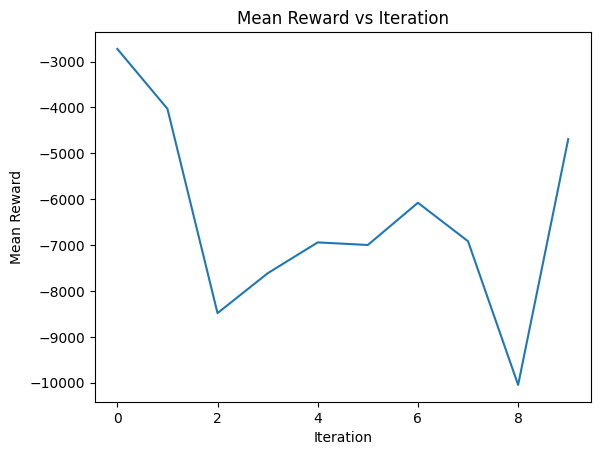

In [ ]:
import matplotlib.pyplot as plt

plt.plot(mean_rewards)
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
plt.title('Mean Reward vs Iteration')
plt.show()